# Sentiment Analysis on selected migration related articles over time (2015-2018)

* The goal of this analysis is to find out which was the evolution of the sentiment projection regarding migration in the media, specifically, in articles from "Der Spiegel".
* We want to use a recurrent neural network model (LSTM) since we want to consider the history on the sentiment over the words/sentences within each article (i.e. if there is a negative estatment we want to consier its impact on the whole sentence).
* In this case we will use a LSTM pre-trained model. It was trained on the Amazon product review dataset introduced in McAuley et al. (2015) [1]. The dataset in de-duplicated form contains over 82 million product reviews from May 1996 to July 2014 amounting to over 38 billion training bytes. Training took one month across four NVIDIA Pascal GPUs, with our model processing 12,500 characters per second.
* The output of the model is the 4,096 hidden units from last layer. As reported in the paper for the binary version of the Stanford Sentiment Treebank (SST), the unit "2,388" contains the sentiment information (see distribution of values for positive and negative labels in the picture below). 
* The authors report two versions of the model, the first is based on [Tensor Flow](https://github.com/openai/generating-reviews-discovering-sentiment) and the second on [PyTorch](https://github.com/guillitte/pytorch-sentiment-neuron). In the current notebook both models will be QA with the sentences provided in [2].

[1] McAuley, Julian, Pandey, Rahul, and Leskovec, Jure. Inferring networks of substitutable and complementary products. In Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, pp. 785–794. ACM, 2015.

[[2]](https://arxiv.org/pdf/1704.01444.pdf) Radford, Alec, Jozefowicz, Rafal, and Sutskever, Ilya. Learning to Generate Reviews and Discovering Sentiment. 2017

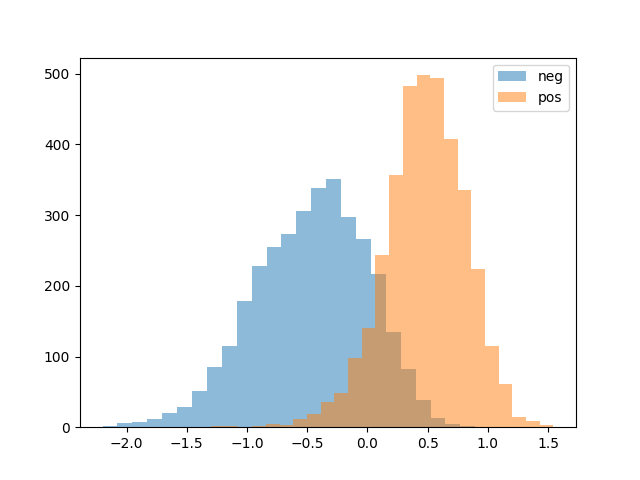

In [44]:
from IPython.display import Image
Image("../../img/sst_binary_sentiment_unit_vis.png")

In [38]:
import sys
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("../../../generating-reviews-discovering-sentiment/")
from encoder import Model

%matplotlib inline

/Users/celsadiaz/.pyenv/versions/3.6.2/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [36]:
from IPython import display
from IPython.core.magic import register_cell_magic, Magics, magics_class, cell_magic
import jinja2

# Code imported from https://gist.github.com/bj0/5343292 for html representation of text sentiment 
# within jupyter notebook

@magics_class
class JinjaMagics(Magics):
    '''Magics class containing the jinja2 magic and state'''
    
    def __init__(self, shell):
        super(JinjaMagics, self).__init__(shell)
        
        # create a jinja2 environment to use for rendering
        # this can be modified for desired effects (ie: using different variable syntax)
        self.env = jinja2.Environment(loader=jinja2.FileSystemLoader('.'))
        
        # possible output types
        self.display_functions = dict(html=display.HTML, 
                                      latex=display.Latex,
                                      json=display.JSON,
                                      pretty=display.Pretty,
                                      display=display.display)

    
    @cell_magic
    def jinja(self, line, cell):
        '''
        jinja2 cell magic function.  Contents of cell are rendered by jinja2, and 
        the line can be used to specify output type.

        ie: "%%jinja html" will return the rendered cell wrapped in an HTML object.
        '''
        f = self.display_functions.get(line.lower().strip(), display.display)
        
        tmp = self.env.from_string(cell)
        rend = tmp.render(dict((k,v) for (k,v) in self.shell.user_ns.items() 
                                        if not k.startswith('_') and k not in self.shell.user_ns_hidden))
        
        return f(rend)
        
    
ip = get_ipython()
ip.register_magics(JinjaMagics)

def extract_color(value):
    return 'rgb({},{},{})'.format(255, 255-int(value*255), 255-int(value*255))

def build_sequence_visualizer(text, sentiment):
    characters = list(text)
    values = pd.DataFrame({'char': characters, 'sentiment': sentiment})
    minn = values['sentiment'].min()
    maxn = values['sentiment'].max()
    values['sentiment'] = (values['sentiment'] - minn) / (maxn - minn)
    values['color'] = values['sentiment'].apply(lambda x: extract_color(x))
    return values



### Evaluate the quality of the LSTM model (first tensorflow version)

In [41]:
# Sentences mentioned in Sutskever et al. 2017 to check if results are reproducible
control_texts = [
    "I found this to be a charming adaptation, very lively and full of fun. With the exception of a couple of major errors, the cast is wonderful. I have to echo some of the earlier comments -- Chynna Phillips is horribly miscast as a teenager. At 27, she's just too old (and, yes, it DOES show), and lacks the singing 'chops' for Broadway-style music. Vanessa Williams is a decent-enough singer and, for a non-dancer, she's adequate. However, she is NOT Latina, and her character definitely is. She's also very STRIDENT throughout, which gets tiresome. The girls of Sweet Apple's Conrad Birdie fan club really sparkle -- with special kudos to Brigitta Dau and Chiara Zanni. I also enjoyed Tyne Daly's performance, though I'm not generally a fan of her work. Finally, the dancing Shriners are a riot, especially the dorky three in the bar. The movie is suitable for the whole family, and I highly recommend it.",
    "Just what I was looking for. Nice fitted pants, exactly matched seam to color contrast with other pants I own. Highly recommended and also very happy!",
    "The package received was blank and has no barcode. A waste of time and money."]

In [42]:
# Initialize an instance of the model
model = Model(root_path="/Users/celsadiaz/github/generating-reviews-discovering-sentiment/")

745.678 seconds to transform 905 examples
125.863 seconds to transform 150 examples
80.720 seconds to transform 77 examples


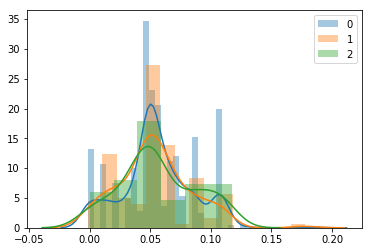

In [45]:
# Extract sentiment from each sentence
values_1 = []
sentiments = []
for i, text in enumerate(control_texts):
    text_features = model.transform(text)
    sentiment = text_features[:, 2388]
    sentiments.append(sentiment)
    
    values = build_sequence_visualizer(text, sentiment)
    values = values.loc[:,('char','color')].to_dict('records')
    values_1.append(values)
    
    sns.distplot(sentiment, label=str(i))
    plt.legend()

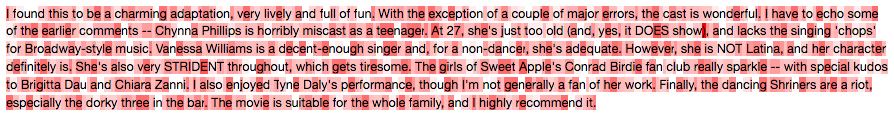

In [51]:
#%%jinja html
#<html>
#<body>
#{% for r in values_1[0] %}<span style="background-color: {{ r.color }} ;">{{ r.char }}</span>{% endfor %} 
#</body>
#</html>
Image("../../img/text0_tf.png")

In [52]:
Image("../../img/text1_tf.png")

In [53]:
Image("../../img/text2_tf.png")

In [54]:
control_tf_version = []
for i, text in enumerate(control_texts):
    case = {}
    case['text'] = text
    case['sentiment'] = sentiments[i]
    control_tf_version.append(case)
    
pickle.dump(control_tf_version, open('../../data/sentiment_control_tensorflow.pkl', "wb"))

The prediction of the sentiment looks like totally random and it can not distinguish properly the difference between the positive and and the negative review examples presented in Sutskever et al. 2017.

### Run sentiment analysis of selected articles in Google Cloud

Performance
- macbook air: 4cores 4GB 
    - article with 319 words/2368 characters 1274.9s -> 21.2’
    - total = 30 articles/quarter x 11 quarters x 21.2' -> 4.8 days
- GC: 4CPUs 15GB
    - article with 319/2368 characters 479.9 -> 7.9’
    - total = 30 articles/quarter x 11 quarters x 7.9' -> 1.8 days

In [ ]:
# load correctly labeled selected articles or get list of indexes ordered by date
selected_articles = pd.read_csv("../../data/330_selected_art_translated_correct.csv")
order_articles_asc = selected_articles.sort_values(by='date_x').index.tolist()
se_order_art_to_quarter = selected_articles.sort_values(by='date_x').quarter

In [ ]:
# load sentiment predicted by tensorflow version lstm model
file_100 = open("../../data/sentiment_analysis_scores_checkpoint.pkl",'rb')
file_100_on = open("../../data/sentiment_analysis_scores.pkl",'rb')
sentiment_100 = pickle.load(file_100)
sentiment_100_on = pickle.load(file_100_on)

sentiment = sentiment_100[:100] + sentiment_100_on

#### Sentiment per article evolution

In [ ]:
# shape results array with sentiment per article to be readable
rec = [{'a_idx': ia, 'sentiment': sent} for ia, a in enumerate(sentiment)  for sent in a]
df = pd.DataFrame.from_records(rec)

# order articles by date (2015 -> 2018)
tmp_ordered = []
for i, art in enumerate(order_articles_asc):
    sel = df[df['a_idx']==art]
    sel['index'] = i
    tmp_ordered.append(sel)
tmp_ordered = pd.concat(tmp_ordered).reset_index(drop=True)

In [ ]:
_=plt.figure(figsize=(25, 15))
_=sns.boxplot(data=tmp_ordered[tmp_ordered['index']>230], x='index', y='sentiment')
_=plt.xticks(rotation=90)

In [ ]:
_=plt.figure(figsize=(25, 15))
_=sns.pointplot(data=tmp_ordered[tmp_ordered['index']>230], x='index', y='sentiment')
_=plt.xticks(rotation=90)

In [ ]:
plt.figure(figsize=(15, 5))
for i in tmp_ordered.a_idx.unique().tolist():#[::5]:
    sns.distplot(tmp_ordered[tmp_ordered['a_idx']==i]['sentiment'], hist=False, rug=False)

#### Sentiment per quarter

In [ ]:
# map quarters to idx_a
tmp_ordered['quarter'] = tmp_ordered['a_idx'].map(se_order_art_to_quarter)

In [ ]:
_=plt.figure(figsize=(15, 5))
_=sns.boxplot(data=tmp_ordered, x='quarter', y='sentiment')
_=plt.xticks(rotation=90)

In [ ]:
_=plt.figure(figsize=(15, 5))
_=sns.pointplot(data=tmp_ordered, x='quarter', y='sentiment')

In [ ]:
plt.figure(figsize=(15, 5))
for i in tmp_ordered.quarter.unique().tolist():
    sns.distplot(tmp_ordered[tmp_ordered['quarter']==i]['sentiment'], hist=False, rug=False)

### Evaluate the quality of the LSTM model (pytorch version)

In [4]:
file = open("../../data/sentiment_control_pytorch.pkl",'rb')
control_sentences = pickle.load(file)

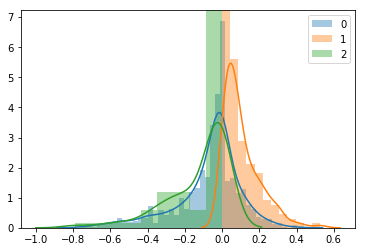

In [27]:
values = []
for i, sentence in enumerate(control_sentences):
    value = build_sequence_visualizer(sentence['text'], sentence['sentiment'])
    value = value.loc[:,('char','color')].to_dict('records')
    values.append(value)

    sns.distplot(sentence['sentiment'], label=str(i))
    plt.legend()

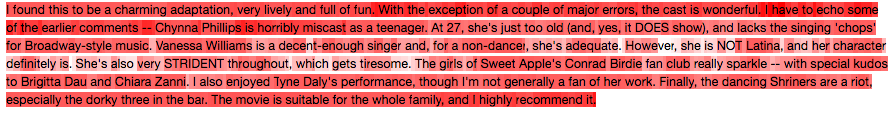

In [31]:
#%%jinja html
#<html>
#<body>
#{% for r in values[0] %}<span style="background-color: {{ r.color }} ;">{{ r.char }}</span>{% endfor %} 
#</body>
#</html>
Image("../../img/text0.png")

In [32]:
Image("../../img/text1.png")

In [33]:
Image("../../img/text2.png")

The model seems to work well since clearly control sentence 1 is more positive and control sentence 2 is more negative.

### Evaluate sentiment of migration related selected articles from Spiegel

In [86]:
file = open("../../data/sentiment_selection_pytorch.pkl",'rb')
sentences = pickle.load(file)

In [94]:
# shape results array with sentiment per article to be readable
rec = [{'a_idx': ia, 'sentiment': sent} for ia, a in enumerate(sentiment)  for sent in a]
df = pd.DataFrame.from_records(rec)

# order articles by date (2015 -> 2018)
tmp_ordered = []
for i, art in enumerate(order_articles_asc):
    sel = df[df['a_idx']==art]
    sel['index'] = i
    tmp_ordered.append(sel)
tmp_ordered = pd.concat(tmp_ordered).reset_index(drop=True)

/Users/celsadiaz/.pyenv/versions/3.6.2/envs/nlp/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [101]:
len(tmp_ordered['a_idx'].unique())

329

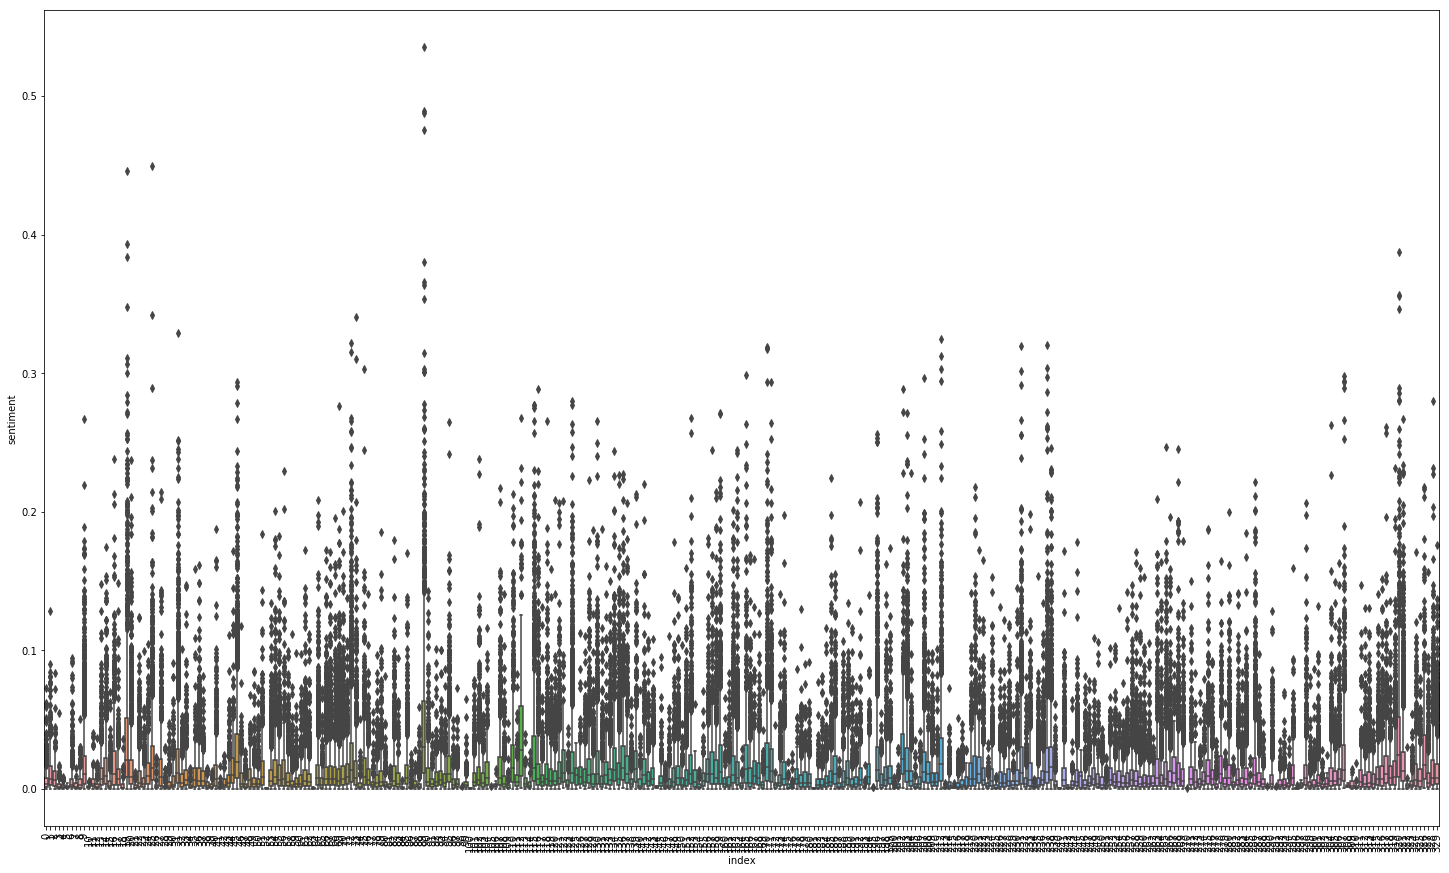

In [104]:
_=plt.figure(figsize=(25, 15))
_=sns.boxplot(data=tmp_ordered, x='index', y='sentiment')
_=plt.xticks(rotation=90)

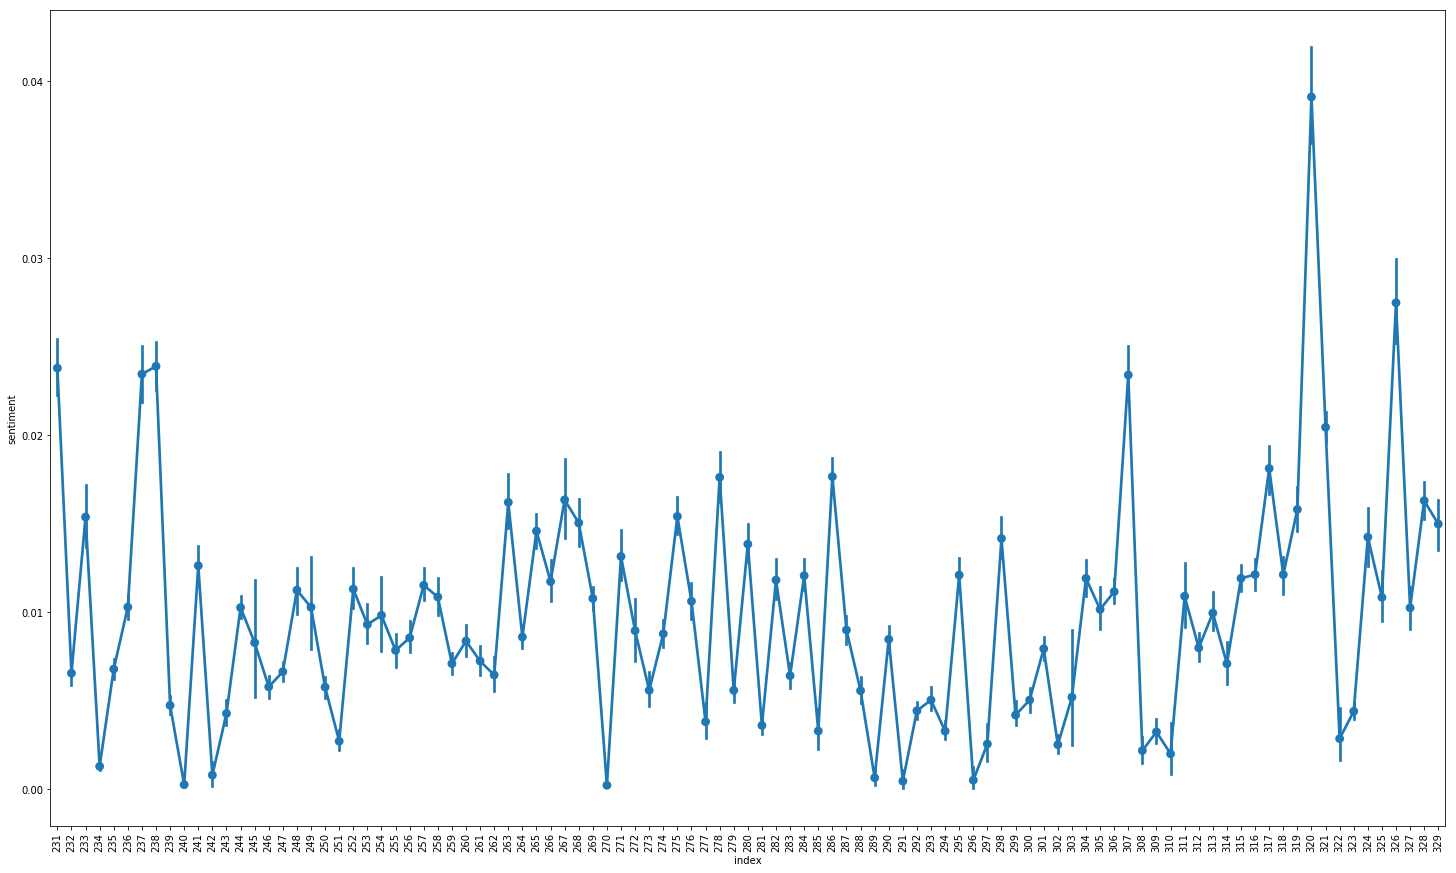

In [105]:
_=plt.figure(figsize=(25, 15))
_=sns.pointplot(data=tmp_ordered[tmp_ordered['index']>230], x='index', y='sentiment')
_=plt.xticks(rotation=90)

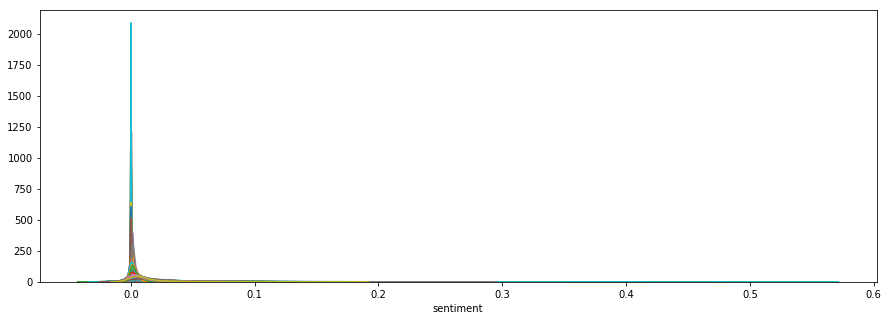

In [107]:
plt.figure(figsize=(15, 5))
for i in tmp_ordered.a_idx.unique().tolist():
    sns.distplot(tmp_ordered[tmp_ordered['a_idx']==i]['sentiment'], hist=False, rug=False)

###### Sentiment per quarter

In [109]:
# map quarters to idx_a
tmp_ordered['quarter'] = tmp_ordered['a_idx'].map(se_order_art_to_quarter)

In [110]:
len(se_order_art_to_quarter)

330

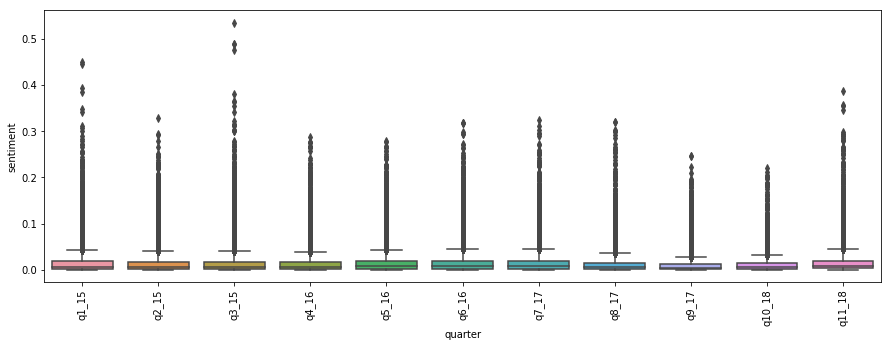

In [111]:
_=plt.figure(figsize=(15, 5))
_=sns.boxplot(data=tmp_ordered, x='quarter', y='sentiment')
_=plt.xticks(rotation=90)

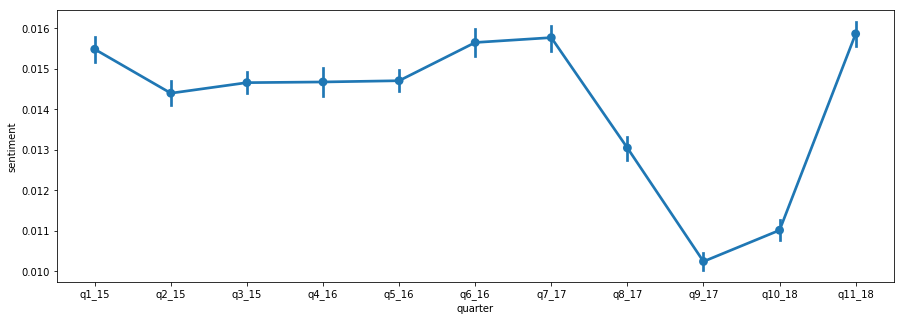

In [112]:
_=plt.figure(figsize=(15, 5))
_=sns.pointplot(data=tmp_ordered, x='quarter', y='sentiment')

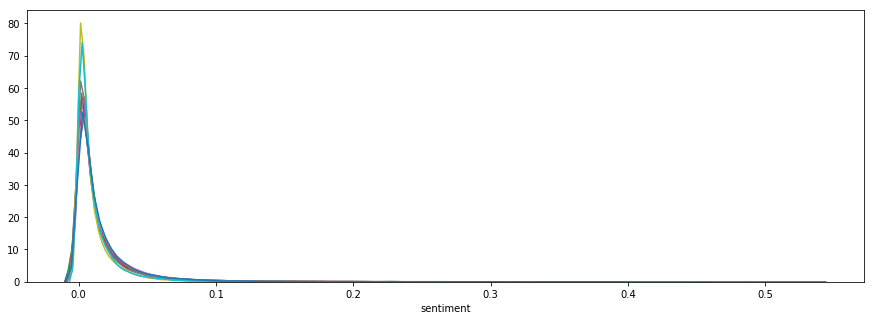

In [113]:
plt.figure(figsize=(15, 5))
for i in tmp_ordered.quarter.unique().tolist():
    sns.distplot(tmp_ordered[tmp_ordered['quarter']==i]['sentiment'], hist=False, rug=False)

### Conclusions

* The LSTM character based model for sentiment feature extraction showed that migration-related articles extracted from Der Spiegel have been neutral during the last 4 years. Good news for journalistic objectivity in Der Spiegel, mainly regarding this sensible topic.

* When analyzing the distribution of the sentiment over all articles, we see that all of them follow the same distribution with 8 peaks (see distribution aggregated by quarters). The differences on the sentiment for each peak is not relevant.

* Comparison of the distribution of quartiles for sentiment values per article over the time showed no relevant differences. Only when comparing the mean values of the sentiment per article aggregated by quarter we see two, almost insignificant, drops around US and DE elections. We can conclude that the only significant difference is on the mean values of the third quarter of 2015 and second quarter of 2016 (as the most positive) and the last quarter of 2017 (as the most negative). Despite of the weakness of the difference between these mean values, the fact is that it is in the third quarter of 2015 and second quarter of 2016 when european citizens and even media started a solidarity wave after the anti-human rights policy of european governments, mainly in 2016. On the other hand, ir is at the end of 2017, with the german elections, when right-populism achieves its strongest support.
* What we see in [Sutskever et al., 2017](https://arxiv.org/pdf/1704.01444.pdf) is that words such as "great", "quite", "mistery", "waste", "tiresome" are the type of words having an impact on the change of the sentiment of the sentences. The model was trained with 82 million Amazon product reviews that mainly contain these kind of words. However, in the migration context, besides of these words, that are not that much present, there are topic specific words with negative and positive connotation depending on the context (i.e. "Populisten", "Abschiebung", "Deutschen", "Demokratie", "Kriminalität", "Videoüberwachung"). The problem with these positive/negetive classification of words by topic is that the classification is pretty subjective, readers of "Das Bild" would consider positive an article that readers of "Taz" will consider as negative.